In [173]:
import tifffile as tf
import zarr
import matplotlib.pyplot as plt
import numpy as np

In [174]:
channel_io = tf.TiffFile('/Users/swarchol/Research/psudo/src/assets/exemplar-001.ome.tif', is_ome=False)

In [175]:
channel_io

<tifffile.TiffFile 'exemplar-001.ome.tif'>

In [176]:
channels = zarr.open(channel_io.series[0].aszarr())

In [177]:
channels[2]

<zarr.core.Array '/2' (12, 785, 628) uint16>

In [178]:
ch_0 = channels[2][0]
ch_1 = channels[2][9]
ch_2 = channels[2][2]
red = np.array([1, 0, 0])
green = np.array([0, 1, 0])
blue = np.array([0, 0, 1])

In [179]:

# Max of this dtype
np.iinfo(ch_0.dtype).max

65535

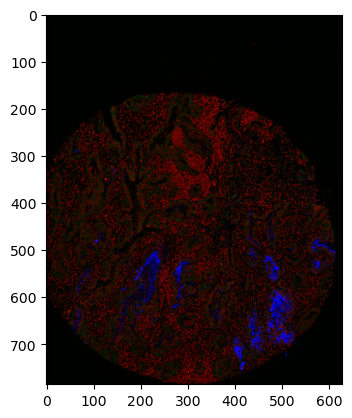

In [180]:
# color ch_0 red  operands could not be broadcast together with shapes (785,628) (3,) 
pseudocolored_ch_0 = ch_0[..., None] / np.iinfo(ch_0.dtype).max * red.reshape(1, 1, 3)
pseudocolored_ch_1 = ch_1[..., None] / np.iinfo(ch_1.dtype).max * green.reshape(1, 1, 3)
pseudocolored_ch_2 = ch_2[..., None] / np.iinfo(ch_2.dtype).max * blue.reshape(1, 1, 3)

# Merge the channels
# pseudocolored = pseudocolored_ch_2 + pseudocolored_ch_1
pseudocolored = pseudocolored_ch_0 + pseudocolored_ch_1 + pseudocolored_ch_2
# clamp between 0 and 1
pseudocolored = np.clip(pseudocolored, 0, 1)
plt.imshow(pseudocolored)


In [192]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

data = np.column_stack((ch_0.flatten() / np.iinfo(ch_0.dtype).max
, ch_1.flatten()/ np.iinfo(ch_0.dtype).max, ch_2.flatten()/ np.iinfo(ch_0.dtype).max, pseudocolored.reshape(-1, 3)))

multi_target_clf = linear_model.LinearRegression()
multi_target_clf.fit(data[:, 0:3], data[:, 3:6])

# Individual single-target regressions
single_target_clfs = [linear_model.LinearRegression() for _ in range(3)]
for i in range(3):
    single_target_clfs[i].fit(data[:, 0:3], data[:, 3+i])

# Compare coefficients and intercepts
print("Multi-target coefficients:", multi_target_clf.coef_)
print("Single-target coefficients:")
for i, clf in enumerate(single_target_clfs):
    print(f"Target {i} coefficients:", clf.coef_)

print("Multi-target intercepts:", multi_target_clf.intercept_)
print("Single-target intercepts:")
for i, clf in enumerate(single_target_clfs):
    print(f"Target {i} intercept:", clf.intercept_)


# Calculate the error
# mean_squared_error(data[:,3:6], clf.predict(data[:,0:3]))

Multi-target coefficients: [[ 1.00000000e+00 -4.06955005e-17 -2.07324921e-18]
 [ 1.33492740e-16  1.00000000e+00  9.71422811e-17]
 [ 1.64216768e-17  2.22044605e-16  1.00000000e+00]]
Single-target coefficients:
Target 0 coefficients: [1.00000000e+00 1.44322957e-18 2.83157983e-19]
Target 1 coefficients: [2.20833648e-16 1.00000000e+00 8.79118004e-17]
Target 2 coefficients: [-5.34416058e-17  6.66133815e-16  1.00000000e+00]
Multi-target intercepts: [ 4.71844785e-16  6.93889390e-17 -3.12250226e-17]
Single-target intercepts:
Target 0 intercept: 4.3021142204224816e-14
Target 1 intercept: 9.8879238130678e-15
Target 2 intercept: 1.9654416982817224e-14


In [182]:
# Save data to csv with values rounded to 3 decimal places
np.savetxt("intensities.csv", data, delimiter=",", fmt='%.3f')

In [183]:
pseudocolored.reshape(-1, 3).shape

(492980, 3)

In [188]:
data[:,3:]

array([[0.00090028, 0.        , 0.00097658],
       [0.00115969, 0.        , 0.0011902 ],
       [0.00109865, 0.        , 0.00091554],
       ...,
       [0.00099184, 0.00604257, 0.0012665 ],
       [0.00103761, 0.00607309, 0.00125124],
       [0.        , 0.00457771, 0.        ]])

In [198]:
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder

iris = datasets.load_iris()
# one-hot encode
enc = OneHotEncoder()
enc.fit(iris.target.reshape(-1, 1))
one_hot_data = enc.transform(iris.target.reshape(-1, 1)).toarray()
one_hot_data.shape

(150, 3)

In [199]:
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [216]:
multi_target_clf = linear_model.LinearRegression()
multi_target_clf.fit(iris.data, one_hot_data)

# Individual single-target regressions
single_target_clfs = [linear_model.LinearRegression() for _ in range(3)]
for i in range(3):
    single_target_clfs[i].fit(iris.data, one_hot_data[:, i])

# Compare coefficients and intercepts
print("Multi-target coefficients:", multi_target_clf.coef_)
# Multi MSE
print("Multi MSE:", mean_squared_error(one_hot_data, multi_target_clf.predict(iris.data)))
print("Single-target coefficients:")
for i, clf in enumerate(single_target_clfs):
    print(f"Target {i} coefficients:", clf.coef_)
    
predictions = None
total_mse = 0
# print("Multi-target intercepts:", multi_target_clf.intercept_)
# print("Single-target intercepts:")
for i, clf in enumerate(single_target_clfs):
    print(f"Target {i} intercept:", clf.intercept_)
    predictions = clf.predict(iris.data)
    loss = ((one_hot_data[:, i] - predictions)**2).mean()
    print("loss", loss)
    # print("predictions", predictions)
    # break
    # Calculate MSE
    # mse = mean_squared_error(one_hot_data[:, i], clf.predict(iris.data))
    total_mse += loss
    # print("MSE:", mse)


print("Total MSE:", total_mse,total_mse/3)




Multi-target coefficients: [[ 0.06602977  0.24284787 -0.22465712 -0.05747273]
 [-0.02015368 -0.44561626  0.22066921 -0.4943066 ]
 [-0.04587608  0.20276839  0.00398791  0.55177932]]
Multi MSE: 0.08978901943983707
Single-target coefficients:
Target 0 coefficients: [ 0.06602977  0.24284787 -0.22465712 -0.05747273]
Target 1 coefficients: [-0.02015368 -0.44561626  0.22066921 -0.4943066 ]
Target 2 coefficients: [-0.04587608  0.20276839  0.00398791  0.55177932]
Target 0 intercept: 0.1182228894681494
loss 0.02044552498274984
Target 1 intercept: 1.5770589738574552
loss 0.16411002151410878
Target 2 intercept: -0.6952818633256035
loss 0.08481151182265241
Total MSE: 0.269367058319511 0.08978901943983701


In [209]:
rust_predictions = np.array([0.9813684006660691, 0.8470032891645377, 0.9046454171116664, 0.8292815366218559, 0.9990513958542689, 1.018551821677789, 0.9179644337027004, 0.9282806577469879, 0.7899344634958813, 0.8553095931567966, 1.0272797788721202, 0.8928759100161064, 0.8467741253791737, 0.8807810126909807, 1.19310731270944, 1.204033513400855, 1.1076563719607058, 0.9750332593713571, 1.0203325779444536, 1.0254990226054552, 0.9099856029258341, 0.9949165810424674, 1.061898725816881, 0.8470399635331937, 0.8260474973039187, 0.8090153191031554, 0.8933342375868345, 0.965656568175416, 0.9636854054778693, 0.8378170043994787, 0.8201340092112791, 0.9418675954778684, 1.1174755110797827, 1.1773567228643045, 0.8553095931567966, 0.9466144699226242, 1.029901758557103, 0.8553095931567966, 0.8364579013348862, 0.934844962827064, 0.9907450918620102, 0.6669559632423196, 0.8849525018714378, 0.9049112552656864, 0.9300593310278262, 0.8341038427897496, 1.009558026329438, 0.8758049744608608, 1.0207154737920439, 0.9263094950494412, 0.22221406101207872, 0.22104536437836825, 0.1405150392275562, 0.06779188668627091, 0.10834433081461207, 0.09077631033415613, 0.18784094313039712, 0.22759174335333068, 0.151826218752388, 0.16102916879516302, 0.0926145722188452, 0.20655765115362373, 0.09537153570251214, 0.09039341448656577, 0.3089445436589189, 0.24510225821576223, 0.12003632320120754, 0.1812032893130097, -0.03455624846454203, 0.157797212463052, 0.10239000238166365, 0.22841421850810695, -0.04435459286255555, 0.07881639680771418, 0.20552602130442355, 0.2142906528674102, 0.08982011220809402, 0.06819270863897471, 0.12204624325323625, 0.28404850938903325, 0.1492617446854294, 0.17787302355087056, 0.213085281865044, -0.06644032400240296, 0.10690771304105533, 0.23694760329990316, 0.17193870420886243, 0.03120177704396311, 0.22181115607354862, 0.11628648722282255, 0.057764378502893454, 0.13691685232557113, 0.16656184402603907, 0.20990874816513108, 0.12679311769799195, 0.21243446487760748, 0.1818520233146197, 0.19239741114427134, 0.32546092519923453, 0.1798808606170731, -0.15876511694149148, -0.09857435804669135, -0.13137587435613207, -0.12230377866869299, -0.15482070856057173, -0.25448731195085605, -0.05982059629012876, -0.21259369086303626, -0.2375880345629503, -0.04922060798670774, 0.06227713756050873, -0.1037408027076927, -0.06196423931344375, -0.13769226738730206, -0.10600276425197597, -0.007844866545162199, -0.06265173066953586, -0.08255588359001467, -0.424410903245495, -0.15906554647834065, -0.06412789142769831, -0.049238534091821495, -0.3123586036833487, -0.01486541621014012, -0.04033891873015094, -0.07958768242609734, 0.02509371654878892, 0.04474787443453501, -0.15899219774102902, -0.07085972523176642, -0.19205955220448945, 0.01007142187174953, -0.16532733903574104, -0.01616496719918664, -0.1828337244548245, -0.14921260160655753, -0.03907812509558639, -0.04496873548133626, 0.06045970692518812, -0.008876496394362499, -0.08556280558010909, 0.04528163372840127, -0.09857435804669135, -0.11524447164923307, -0.06567948390899919, -0.014370414270756082, -0.09197129561213302, -0.008493600546772118, 0.005244986260507567, -0.012933010867075628])

In [211]:
(predictions - rust_predictions).mean()

2.7792583049783086e-16